In [59]:
import math
import random
from graphviz import Digraph

In [60]:
class Value:
    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.label = label
        self.prev = children
        self.operation = operation
        self.grad = 0.0
        self.backward = lambda : None

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out.backward = _backward
        return out

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out.backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out.backward = _backward

        return out

    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1
    
    def tanh(self):
        out = Value(math.tanh(self.data), (self, ), 'tanh')

        def _backward():
            self.grad += (1 - math.tanh(self.data)**2) * out.grad
        out.backward = _backward

        return out
    
    def top_backward(self):
        self.grad = 1.0

        def backward_recursion(parent_node):
            parent_node.backward()
            for node in parent_node.prev:
                backward_recursion(node)
        
        backward_recursion(self)


In [61]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n.operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.operation, label = n.operation)
      # and connect this node to it
      dot.edge(uid + n.operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

  return dot

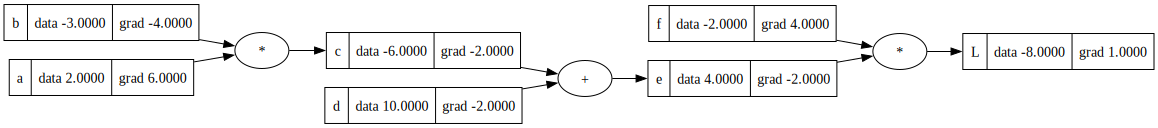

In [62]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
d = Value (10.0, label='d')
f = Value (-2.0, label='f')

c = a * b; c.label='c'
e = c + d; e.label='e'
L = e * f; L.label='L'
L.top_backward()
draw_dot(L)

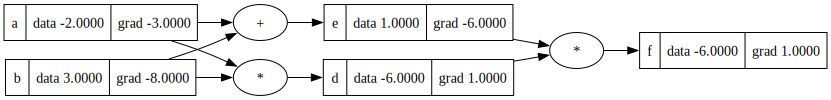

In [63]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.top_backward()

draw_dot(f)

In [64]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.top_backward()

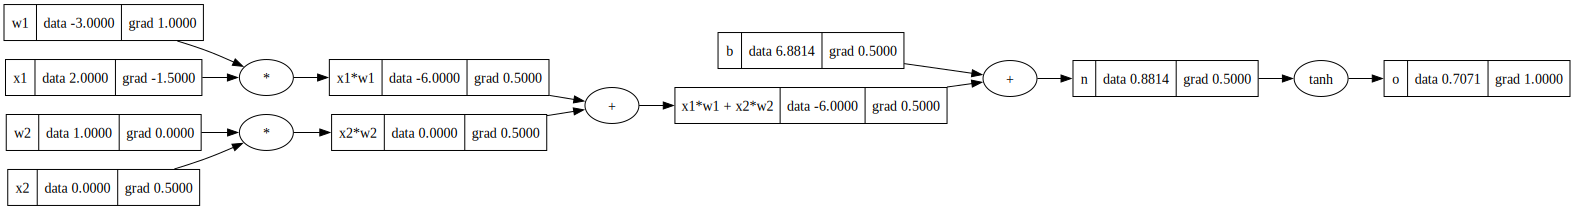

In [65]:
draw_dot(o)

In [66]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        activation = sum( xi*wi for xi, wi in zip(x, self.w)) + self.b
        return activation.tanh()
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    
    def parameters(self):
        return [parameters for neuron in self.neurons for parameters in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        mlp = [nin] + nouts
        self.layers = [Layer(mlp[n], mlp[n+1]) for n in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [parameters for layer in self.layers for parameters in layer.parameters()]

In [67]:
nn = MLP(3, [4, 4, 1])

In [68]:
def describe_mlp(nn):
    for i, layer in enumerate(nn.layers):
        print('layer: ', i + 1)
        for ni, neuron in enumerate(layer.neurons):
            print('neuron', ni + 1)
            for wi, w in enumerate(neuron.w):
                print(f'w{wi + 1}: {w.data}')
            print(f'b: {neuron.b.data}')
        print('')

In [69]:
describe_mlp(nn)

layer:  1
neuron 1
w1: 0.7075938052927726
w2: 0.5175944631165732
w3: 0.4401978621340221
b: -0.5245386655485407
neuron 2
w1: -0.5300821620433227
w2: -0.8668069286249305
w3: 0.6400274798986703
b: -0.849828244773345
neuron 3
w1: 0.2770635874812346
w2: -0.46105597916679364
w3: 0.7956762102267065
b: -0.2672691702923047
neuron 4
w1: -0.034747521283607474
w2: 0.8527426520749464
w3: 0.27487555512160644
b: 0.40337083753309955

layer:  2
neuron 1
w1: 0.8211918085481213
w2: 0.9484329209934084
w3: 0.9374349012592424
w4: -0.002822138127117846
b: 0.24722796058844287
neuron 2
w1: -0.9922445553480526
w2: -0.22266464440068634
w3: -0.814945235778278
w4: -0.9119725989149028
b: 0.013210795669080122
neuron 3
w1: -0.9031383392870262
w2: -0.46377304901745564
w3: 0.5625451684540586
w4: -0.6138752445998998
b: 0.13236318978210448
neuron 4
w1: 0.24296696989965239
w2: -0.0008493410878802621
w3: 0.0678814524763709
w4: -0.9189013855193227
b: -0.3495741452850101

layer:  3
neuron 1
w1: 0.9496734109029494
w2: -0.5162

In [70]:
inputs = [
  [2.0, 1.0, -1.0],
  [3.0, 2.0, -2.0],
  [5.0, 3.0, 1.0],
  [2.0, 4.0, 3.0],
  [0.0, 3.0, -1.0],
  [3.0, 1.0, 3.0],

]
desired_outputs = [-1.0, -1.0, -1.0, 1.0, 1.0, -1.0]


In [71]:
for i in range(3000):
    h = 0
    if i <= 1000:
        h = 0.1
    elif i <= 2000:
        h = 0.05
    else:
        h = 0.01

    predicted_values = [nn(x) for x in inputs]

    loss = sum([(predicted-desired)**2 for desired, predicted in zip(desired_outputs, predicted_values)])

    for p in nn.parameters():
        p.grad = 0
    loss.top_backward()

    for p in nn.parameters():
        p.data += -0.1 * p.grad
  
    print(i, loss.data)

0 14.049579383181364
1 5.170611632315697
2 6.7593263310346625
3 7.932010433143616
4 7.92316528969028
5 7.911822053725193
6 7.896801711252244
7 7.876080584394445
8 7.845908634796521
9 7.798603216945959
10 7.7161337436313655
11 7.547338180795767
12 7.104714289948697
13 5.71482404280303
14 7.302020336596401
15 7.935241847992055
16 7.927300649093522
17 7.917256638192167
18 7.904185970865417
19 7.886554435644648
20 7.861636997847974
21 7.8241555176178945
22 7.762639668994596
23 7.647893269433611
24 7.387285645277031
25 6.606362654595624
26 5.526285867068706
27 6.641704780723575
28 5.4599216229995235
29 6.307887542677824
30 6.219759549407155
31 7.719614243235899
32 7.562012723223683
33 7.1683331828287296
34 5.948048777927037
35 6.889917400117689
36 7.861819755084054
37 7.826609892992996
38 7.770623479507117
39 7.671241267792528
40 7.46333682837758
41 6.91184097072002
42 5.461795322318156
43 6.102075267312159
44 7.498509348770243
45 7.041040648558644
46 5.760820641706897
47 6.442128710179707


In [72]:
predicted_values = [nn(x) for x in inputs]
predicted_values

[Value(data=-0.9959342537272827),
 Value(data=-0.9959398435788973),
 Value(data=-0.9959417558955644),
 Value(data=0.9944228312074671),
 Value(data=0.9944438314840635),
 Value(data=-0.9959416868538729)]

In [73]:
describe_mlp(nn)

layer:  1
neuron 1
w1: -8.334820118288302
w2: -0.7143509549480905
w3: 2.1222809097292066
b: -0.9303556407471933
neuron 2
w1: 11.234688346436043
w2: 18.888439485188346
w3: 7.630229605016083
b: 0.05840762831976998
neuron 3
w1: -11.866239613031894
w2: -4.888208263509962
w3: 2.6471862612980637
b: -0.9235531207334052
neuron 4
w1: 2.870574461583047
w2: -2.3287094688407772
w3: -0.14014410843183478
b: 0.37083831988178795

layer:  2
neuron 1
w1: 0.5013563431948542
w2: 1.0926635795065665
w3: 0.884796076011695
w4: -0.9298616735116231
b: 0.25583170282015455
neuron 2
w1: -1.0375128289497733
w2: -0.08842542639815003
w3: -1.018759993981315
w4: -0.5056240034974078
b: 0.23537580809465264
neuron 3
w1: -0.7680369517945115
w2: -0.007993171921839001
w3: 0.740966624585536
w4: -0.9700841961374764
b: -0.05853798239740041
neuron 4
w1: 0.21640436748390657
w2: 0.1930223314195157
w3: -0.12822533319405768
w4: -1.5531119512485283
b: -0.1247326681225459

layer:  3
neuron 1
w1: 0.9338207794266213
w2: -0.4138280569654